# Getting Started with Sionna

In [3]:
#conda create -n sionna_win python=3.10
#conda activate sionna_win


In [4]:
import sionna as sn

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import json
from statsmodels.tsa.ar_model import AutoReg
import numpy as np
from sympy import Matrix
import json
import argparse
import tensorflow as tf
import math

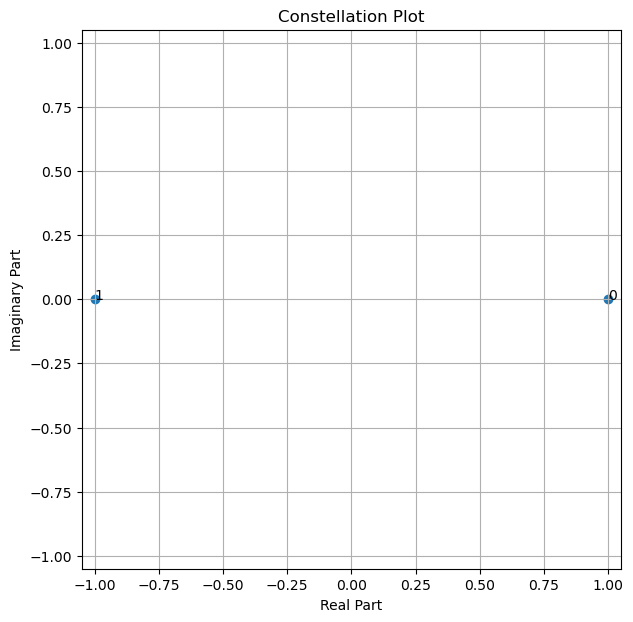

In [6]:
NUM_BITS_PER_SYMBOL = 1 # BPSK
constellation = sn.mapping.Constellation("pam", NUM_BITS_PER_SYMBOL, normalize = True)
constellation.show();

In [7]:
# The mapper uses the same constellation object as the demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

In [8]:
binary_source = sn.utils.BinarySource()

In [9]:
no = sn.utils.ebnodb2no(ebno_db=10.0,num_bits_per_symbol=NUM_BITS_PER_SYMBOL,coderate=1.0) # Coderate set to 1 as we do uncoded transmission here
awgn_channel = sn.channel.AWGN()

In [49]:
BATCH_SIZE = 1 # How many examples are processed by Sionna in parallel

bits = binary_source([BATCH_SIZE,1024]) # Blocklength
print("Shape of bits: ", bits.shape)

x = mapper(bits)
print("Shape of x: ", x.shape)

y = awgn_channel([x, no])
print("Shape of y: ", y.shape)

llr = demapper([y, no])
print("Shape of llr: ", llr.shape)

Shape of bits:  (1, 1024)
Shape of x:  (1, 1024)
Shape of y:  (1, 1024)
Shape of llr:  (1, 1024)


In [50]:
len(x)

1

In [11]:
num_samples = 8 # how many samples shall be printed
num_symbols = int(num_samples/NUM_BITS_PER_SYMBOL)

print(f"First {num_samples} transmitted bits: {bits[0,:num_samples]}")
print(f"First {num_symbols} transmitted symbols: {np.round(x[0,:num_symbols], 2)}")
print(f"First {num_symbols} received symbols: {np.round(y[0,:num_symbols], 2)}")
print(f"First {num_samples} demapped llrs: {np.round(llr[0,:num_samples], 2)}")

First 8 transmitted bits: [0. 0. 0. 0. 1. 1. 0. 0.]
First 8 transmitted symbols: [ 1.+0.j  1.+0.j  1.+0.j  1.+0.j -1.+0.j -1.+0.j  1.+0.j  1.+0.j]
First 8 received symbols: [ 1.05-0.16j  0.92+0.23j  0.98-0.12j  0.73-0.55j -0.83+0.12j -0.93+0.3j
  0.88-0.06j  0.63+0.19j]
First 8 demapped llrs: [-42.13 -36.83 -39.18 -29.23  33.16  37.19 -35.05 -25.28]


# Keras API to perform Uncoded AWGN BPSK transmission

In [10]:
class UncodedBPSKSystemAWGN(tf.keras.Model):
    def __init__(self, block_length):
        """
        Uncoded BPSK transmission over AWGN channel model.

        Parameters
        ----------
        block_length: int
            Number of bits per transmitted block

        Input
        -----
        batch_size: int
            Batch size for Monte-Carlo simulation
        ebno_db: float
            Eb/No value in dB

        Output
        ------
        (bits, llr): tuple
            Tuple containing transmitted bits and received LLRs
        """
        super().__init__()
        
        # Force BPSK configuration
        self.num_bits_per_symbol = 1  # Fixed for BPSK
        self.block_length = block_length
        
        # BPSK constellation setup
        self.constellation = sn.mapping.Constellation(
            constellation_type="pam",
            num_bits_per_symbol=self.num_bits_per_symbol,
            normalize=True  # Normalize to unit energy
        )
        
        # System components
        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)
        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()

    def call(self, batch_size, ebno_db):
        # Convert Eb/No to noise variance
        no = sn.utils.ebnodb2no(
            ebno_db,
            num_bits_per_symbol=self.num_bits_per_symbol,
            coderate=1.0  # Uncoded
        )

        # Generate random bits [batch_size, block_length]
        bits = self.binary_source([batch_size, self.block_length])
        
        # Map to BPSK symbols (0->+1, 1->-1)
        x = self.mapper(bits)
        
        # Add AWGN noise
        y = self.awgn_channel([x, no])
        
        # Compute LLRs (log-likelihood ratios)
        llr = self.demapper([y, no])
        
        return bits, llr


In [11]:
model_uncoded_awgn = UncodedBPSKSystemAWGN(block_length=1024)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 1.5837e-01 | 1.0000e+00 |    32434502 |   204800000 |       200000 |      200000 |        23.0 |reached max iter       
   -2.421 | 1.4228e-01 | 1.0000e+00 |    29138733 |   204800000 |       200000 |      200000 |        25.1 |reached max iter       
   -1.842 | 1.2629e-01 | 1.0000e+00 |    25864756 |   204800000 |       200000 |      200000 |        24.0 |reached max iter       
   -1.263 | 1.1072e-01 | 1.0000e+00 |    22675226 |   204800000 |       200000 |      200000 |        23.0 |reached max iter       
   -0.684 | 9.5598e-02 | 1.0000e+00 |    19578391 |   204800000 |       200000 |      200000 |        38.6 |reached max iter       
   -0.105 | 8.1206e-02 | 1.0000e+00 |    16631066 |   204800000 |       200000 |     

(<tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([0.15837159, 0.14227897, 0.12629275, 0.11071888, 0.09559761,
        0.08120638, 0.0676543 , 0.05520583, 0.04394048, 0.0340654 ,
        0.02559532, 0.01857057, 0.01294912, 0.00862729, 0.00545585,
        0.00325684, 0.0018148 , 0.00094237, 0.00044544, 0.00018881])>,
 <tf.Tensor: shape=(20,), dtype=float64, numpy=
 array([1.      , 1.      , 1.      , 1.      , 1.      , 1.      ,
        1.      , 1.      , 1.      , 1.      , 1.      , 1.      ,
        1.      , 0.999865, 0.996065, 0.964855, 0.845565, 0.617915,
        0.36602 , 0.175425])>)

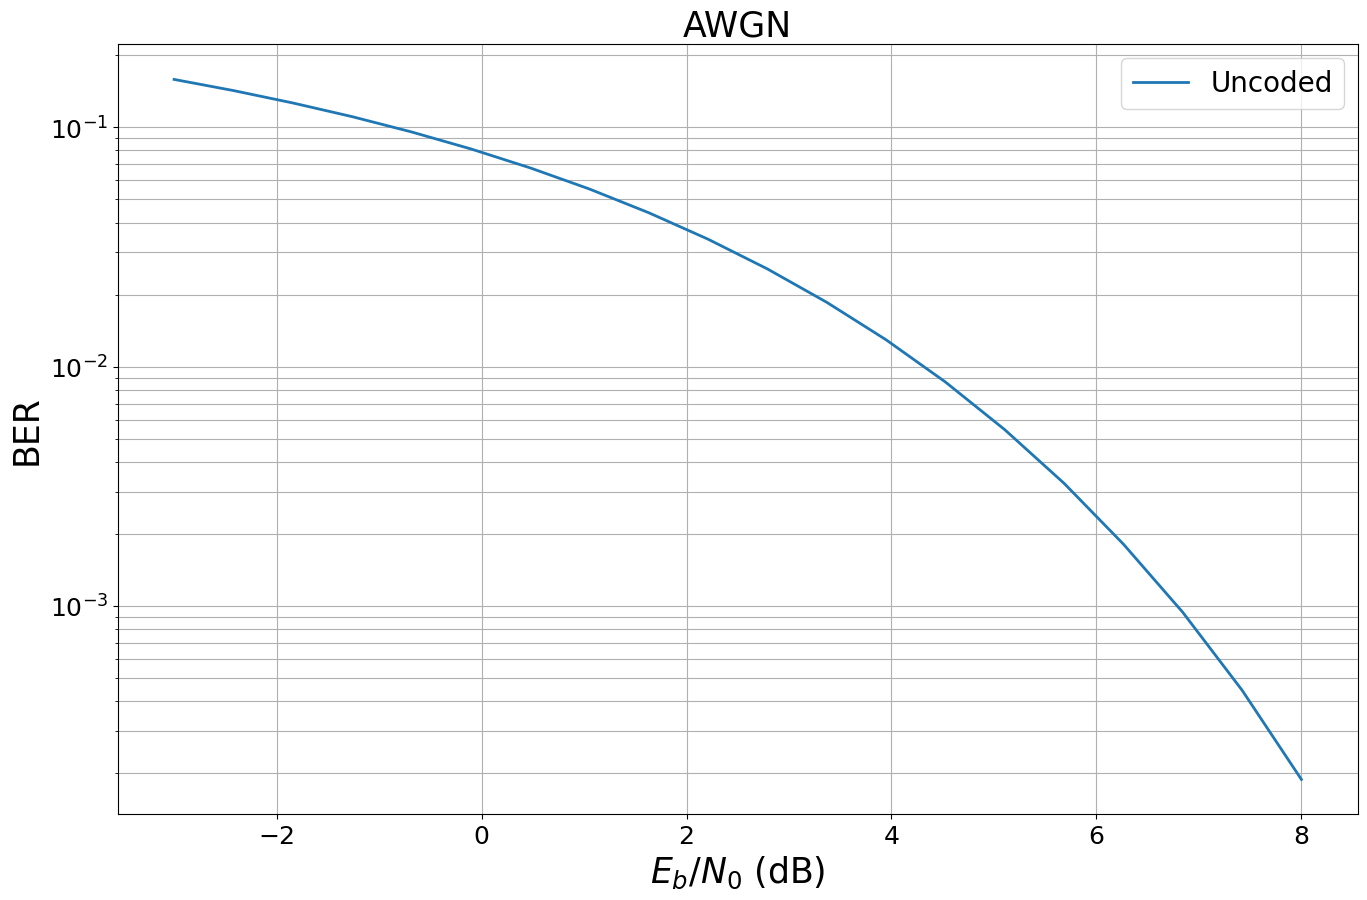

In [12]:
EBN0_DB_MIN = -3.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 8.0 # Maximum value of Eb/N0 [dB] for simulations
BATCH_SIZE = 2000 # How many examples are processed by Sionna in parallel

ber_plots = sn.utils.PlotBER("AWGN")
ber_plots.simulate(model_uncoded_awgn,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  legend="Uncoded", 
                  soft_estimates=True,
                  max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=True)

# LDPC with BPSK on AWGN channel

In [12]:
class CodedBPSKSystemAWGN(tf.keras.Model): # Inherits from Keras Model
    def __init__(self, n, coderate):
        super().__init__() # Must call the Keras model initializer

        self.n = n
        self.k = int(n*coderate)
        self.coderate = coderate
        self.constellation = sn.mapping.Constellation("pam", 1)

        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)

        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()

        self.encoder = sn.fec.ldpc.LDPC5GEncoder(self.k, self.n)
        self.decoder = sn.fec.ldpc.LDPC5GDecoder(self.encoder, hard_out=True)

    #@tf.function # activate graph execution to speed things up
    def __call__(self, batch_size, ebno_db):
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=1, coderate=self.coderate)

        bits = self.binary_source([batch_size, self.k])
        codewords = self.encoder(bits)
        x = self.mapper(codewords)
        y = self.awgn_channel([x, no])
        llr = self.demapper([y,no])
        bits_hat = self.decoder(llr)
        return bits, bits_hat

In [13]:
CODERATE = 0.5
BATCH_SIZE = 2000

model_coded_awgn = CodedBPSKSystemAWGN(n=2048,coderate=CODERATE)

In [ ]:
CODERATE = 0.5
BATCH_SIZE = 2000

model_coded_awgn = CodedBPSKSystemAWGN(n=2048,coderate=CODERATE)
ber_plots.simulate(model_coded_awgn,
                   ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 15),
                   batch_size=BATCH_SIZE,
                   legend="Coded",
                   soft_estimates=False,
                   max_mc_iter=15,
                   show_fig=True,
                   forward_keyboard_interrupt=False);

In [17]:
@tf.function() # enables graph-mode of the following function
def run_graph(batch_size, ebno_db):
    # all code inside this function will be executed in graph mode, also calls of other functions   
    return model_coded_awgn(batch_size, ebno_db)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 2.7956e-01 | 1.0000e+00 |    11450602 |    40960000 |        40000 |       40000 |       116.4 |reached max iter       
     -2.0 | 2.5083e-01 | 1.0000e+00 |    10274114 |    40960000 |        40000 |       40000 |       123.9 |reached max iter       
     -1.0 | 2.1566e-01 | 1.0000e+00 |     8833522 |    40960000 |        40000 |       40000 |       358.8 |reached max iter       
      0.0 | 1.6089e-01 | 1.0000e+00 |     6589999 |    40960000 |        40000 |       40000 |       125.1 |reached max iter       
      1.0 | 2.0458e-02 | 4.6860e-01 |      837956 |    40960000 |        18744 |       40000 |       135.7 |reached max iter       
      2.0 | 5.1270e-07 | 7.5000e-05 |          21 |    40960000 |            3 |     

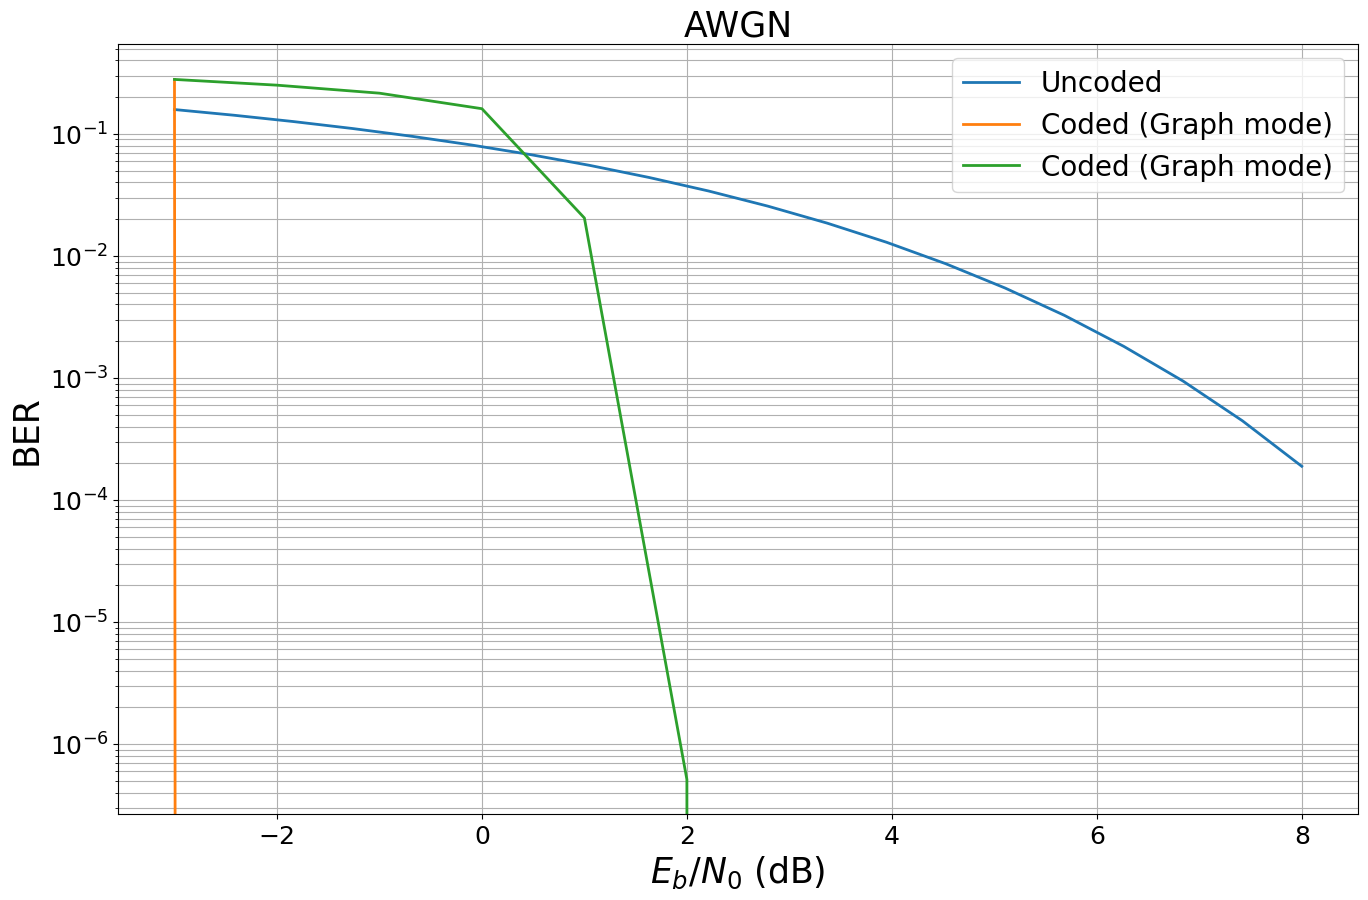

In [19]:
ber_plots.simulate(run_graph,
                   ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 12),
                   batch_size=BATCH_SIZE,
                   legend="Coded (Graph mode)",
                   soft_estimates=True,
                   max_mc_iter=20,
                   show_fig=True,
                   forward_keyboard_interrupt=False);

# Recreating the AR uncoded results

In [12]:
# Parameters
#The number of channel samples we estimate into the future 
packet_size = 50
#The number of pilot samples we transmit incase of retransmission
pilot_size = 50
#Order of our VAR model
var_order = 25
#MSE threshold to decide if a retransmission is required incase of VAR-based estimation
mse_threshold = 0.1
#SNR in dB
ebno_db = 10 
#Minimum number of samples needed for VAR fitting + buffer
initial_pilots = var_order + 2  

In [12]:
# def generate_random_bits(n):
#     """
#     Generate random bits as either -1 or 1.

#     Args:
#         n (int): Number of bits to generate.

#     Returns:
#         np.ndarray: Array of random bits (-1 or 1) of size n.
#     """
#     # Generate n random bits as -1 or 1 using uniform sampling.
#     return np.random.choice([-1, 1], size=n)


# def transmit_data(data, channel, ebno_db, coderate = 0.5):
#     """
#     Simulate data transmission over a wireless channel with noise.

#     Args:
#         data (np.ndarray): Input data to be transmitted.
#         channel (complex or float): Channel gain.
#         ebno_db (float): Signal-to-noise ratio in decibels (dB). 

#     Returns:
#         np.ndarray: Noisy received signal.
#     """
#     # Apply channel gain to the transmitted data.
#     signal = channel * data
#     # Calculate the signal power.
#     signal_power = np.mean(np.abs(signal)**2)
#     # Convert SNR from dB to linear scale and compute noise power.
#     noise_power = signal_power / (10**(ebno_db / 10) * coderate )
#     # Generate complex Gaussian noise.
#     noise = np.sqrt(noise_power / 2) * (np.random.randn(len(data)) + 1j * np.random.randn(len(data)))
#     # Add noise to the signal to create the received signal.
#     return signal + noise


# def estimate_channel(received, data):
#     """
#     Estimate the channel coefficient using least squares.

#     Args:
#         received (np.ndarray): Received signal.
#         data (np.ndarray): Transmitted data.

#     Returns:
#         complex or float: Estimated channel coefficient, of the same length as X, so a packetwise(pointwise) estimation is performed
#     """
#     # Reshape the transmitted data for matrix operations.
#     X = data.reshape(-1, 1)
#     # Perform least squares estimation to solve for the channel.
#     h = np.linalg.lstsq(X, received, rcond=None)[0][0]
#     return h


# def collect_pilot_estimates(current_index, num_pilots, channel_vals, ebno_db, pilot_size=50):
#     # List to store channel estimates.
#     estimates = []
#     # Collect channel estimates for the specified number of pilots.
#     for _ in range(num_pilots):
#         # Check if the remaining channel values are sufficient for a pilot.
#         if current_index + pilot_size > len(channel_vals):
#             break

#         # Generate pilot bits for transmission.
#         pilot_bits = generate_random_bits(pilot_size)
#         # Extract the actual channel values for the current pilot.
#         actual_channel = channel_vals[current_index:current_index + pilot_size]
#         # Simulate the transmission and reception of pilot data.
#         received_pilot = transmit_data(pilot_bits, actual_channel, ebno_db)
#         # Estimate the channel from the received pilot data.
#         hbar = estimate_channel(received_pilot, pilot_bits)
#         # Store the estimated channel coefficient.
#         estimates.append(hbar)
#         # Move the index forward by the size of the pilot.
#         current_index += pilot_size

#     return estimates, current_index


# def predict_channel_var(channel_history, var_order = 25, steps=1):
#     """
#     Predict the future channel value using a Vector AutoRegressive (VAR) model.

#     Args:
#         channel_history (np.ndarray): Historical channel values as a 1D array of complex numbers.
#         steps (int): Number of future steps to predict. Default is 1.

#     Returns:
#         complex: Predicted channel value as a complex number.

#     Raises:
#         ValueError: If the length of `channel_history` is less than or equal to the VAR model order.
#     """
#     # Ensure there are enough samples for the VAR model.
#     if len(channel_history) <= var_order:
#         raise ValueError(f"Not enough samples for VAR. Need >{var_order}, got {len(channel_history)}")
#     # Separate real and imaginary parts of the channel history for the VAR model.
#     channel_history_separated = np.column_stack((np.real(channel_history), np.imag(channel_history)))
#     # Create and fit the VAR model using the specified order.
#     model = VAR(channel_history_separated)
#     results = model.fit(var_order)
#     # Forecast future values based on the fitted model and past data.
#     forecast = results.forecast(channel_history_separated[-var_order:], steps=steps)
#     # Combine the real and imaginary parts to return the predicted complex channel value.
#     return forecast[0, 0] + 1j * forecast[0, 1]



# def generate_channels_for_doppler_frequencies(Fd, Fs, N):
#     """
#     Generate correlated Jakes channels for given Doppler frequencies using the Sum-of-Sinusoids (SoS) method.

#     Args:
#         Fd (float): Maximum Doppler frequency (Hz).
#         Fs (float): Sampling frequency (Hz).
#         N (int): Number of samples to generate.

#     Returns:
#         np.ndarray: Correlated Jakes random variables (complex values) for the generated channels.
#     """
#     def jakes_sos(P, K, Fs, Fd, N, typ):
#         """
#         Generate Jakes random variables using the Sum-of-Sinusoids (SoS) method.

#         Args:
#             P (int): Number of time points.
#             K (int): Number of independent processes.
#             Fs (float): Sampling frequency (Hz).
#             Fd (float): Maximum Doppler frequency (Hz).
#             N (int): Number of sinusoids used in the model.
#             typ (str): Type of signal to generate ('comp' for complex, others for real).

#         Returns:
#             np.ndarray: Jakes random variables (complex values).
#         """
#         # Create a time vector for sampling points
#         t = np.linspace(0, P / Fs, P)
#         # Calculate angular Doppler frequency
#         omega_d = 2 * np.pi * Fd
#         # Initialize an array to store Jakes random variables
#         jakes_rvs = np.zeros((K, P), dtype=complex)
        
#         # Loop through independent processes
#         for k in range(K):
#             # Generate random angles for sinusoids
#             alpha = np.random.uniform(0, 2 * np.pi, N)
#             # Adjust angles based on the number of sinusoids
#             alpha_m = np.array([((2 * np.pi * n) - np.pi + al) / (4 * N) for n, al in enumerate(alpha)])
#             # Generate random phase offsets for cosine terms
#             a_m = np.random.uniform(0, 2 * np.pi, N)
#             # Generate random phase offsets for sine terms
#             b_m = np.random.uniform(0, 2 * np.pi, N)
#             # Compute cosine terms for the real part
#             cosine_terms = np.cos((omega_d * t[:, None] * np.cos(alpha_m)) + a_m)
#             # Sum the cosine contributions to form the real part
#             real_part = np.sqrt(1 / N) * np.sum(cosine_terms, axis=1)

#             # Check if generating complex signals
#             if typ == 'comp':
#                 # Compute sine terms for the imaginary part
#                 sine_terms = np.sin((omega_d * t[:, None] * np.cos(alpha_m)) + b_m)
#                 # Sum the sine contributions to form the imaginary part
#                 imag_part = np.sqrt(1 / N) * np.sum(sine_terms, axis=1)
#                 # Combine real and imaginary parts
#                 jakes_rvs[k] = real_part + 1j * imag_part
#             else:
#                 # Enforce complex format with zero imaginary part for real signals
#                 jakes_rvs[k] = real_part + 1j * 0

#         # Return the generated Jakes random variables
#         return jakes_rvs

#     # Number of time points for the output
#     P = N
#     # Number of independent processes to simulate
#     K = 1
#     # Specify the type of random variables (complex)
#     typ = 'comp'
#     # Set the center frequency
#     Fc = 1000000000
#     # Generate Jakes random variables using the SoS method
#     jakes_rvs = jakes_sos(P, K, Fs, Fd, 100, typ)
#     correlated_jakes_rvs = jakes_rvs

#     # Open a file to write the generated channels
#     with open("channels.txt", "w") as fo:
#         # Iterate through each sample
#         for i in range(P):
#             # Extract the i-th sample
#             new_sample = correlated_jakes_rvs[:, i]
#             # Serialize complex numbers as (real, imag) pairs
#             new_sample_serialized = [(z.real, z.imag) for z in new_sample]
#             # Write serialized sample to the file
#             json.dump(new_sample_serialized, fo)
#             # Add a newline after each serialized sample
#             fo.write('\n')

#     # Return the generated Jakes random variables
#     return correlated_jakes_rvs


In [111]:
# Fd = 1000
# Fs = 100000
# N = 100000
# # Generate and save channels for the given Doppler frequency.
# generate_channels_for_doppler_frequencies(Fd, Fs, N)

# # Load the complex channel values from the file.
# with open("channels.txt", "r") as f:
#     channel_vals = [json.loads(line)[0] for line in f]
# channel_vals = np.array([complex(re, im) for re, im in channel_vals])

In [111]:
def doppler_spectrum(Fd, Fs, P):    
    freqs = np.fft.fftfreq(P, d=1/Fs)
    freqs = np.fft.fftshift(freqs)
    doppler_filter = np.zeros(P)
    
    for i, f in enumerate(freqs):
        if abs(f) < Fd:
            doppler_filter[i] = 1.0 / (np.pi * Fd * np.sqrt(1 - (f/Fd)**2))
    
    doppler_filter = np.nan_to_num(doppler_filter, nan=0, posinf=0, neginf=0)
    power = np.sum(np.abs(doppler_filter)**2) / len(doppler_filter)
    doppler_filter = doppler_filter / np.sqrt(power)
    
    return doppler_filter

def jakes_doppler(P, K, Fs, Fd):
    doppler_filter = doppler_spectrum(Fd, Fs, P)
    jakes_rvs = np.zeros((K, P), dtype=complex)
    
    for k in range(K):
        noise = (np.random.normal(0, 1/np.sqrt(2), P) + 
                1j * np.random.normal(0, 1/np.sqrt(2), P))
        
        noise_shifted = np.fft.fftshift(noise)
        filtered_spectrum = noise_shifted * doppler_filter
        filtered_spectrum_unshifted = np.fft.ifftshift(filtered_spectrum)
        
        fading_spectrum = np.fft.ifft(filtered_spectrum_unshifted)
        power = np.mean(np.abs(fading_spectrum)**2)
        fading_spectrum = fading_spectrum / np.sqrt(power)
        
        jakes_rvs[k] = fading_spectrum
    
    return jakes_rvs[0]

def generate_random_bits(n):
    return np.random.choice([-1, 1], size=n)

def transmit_data(data, channel, ebno_db, coderate = 0.5):
    signal = channel * data
    signal_power = np.mean(np.abs(data)**2)
    noise_power = signal_power / (10**(ebno_db/10) * coderate)
    noise = np.sqrt(noise_power/2) * (np.random.randn(len(data)) + 1j * np.random.randn(len(data)))
    return signal + noise

def estimate_channel(received, data):
    X = data.reshape(-1, 1)
    h = np.linalg.lstsq(X, received, rcond=None)[0][0]
    return h

def predict_channel_var(channel_history, var_order):
    channel_history_separated = np.column_stack((np.real(channel_history), np.imag(channel_history)))
    model = VAR(channel_history_separated)
    results = model.fit(var_order)
    forecast = results.forecast(channel_history_separated[-var_order:], steps=1)
    return forecast[0, 0] + 1j * forecast[0, 1]

In [112]:
def autoreg_simulate(Fd, Fs, channel_vals, mse_threshold, N, ebno_db, packet_size=50, pilot_size=50, var_order=25, initial_pilots=50):
    binary_source = sn.utils.BinarySource()
    constellation = sn.mapping.Constellation("pam", num_bits_per_symbol=1)
    mapper = sn.mapping.Mapper(constellation=constellation)
    demapper = sn.mapping.Demapper("app", constellation=constellation)
    
    # For uncoded transmission, coderate=1.0
    coderate = 1.0
    
    # Maintain original control flow structure
    current_index = 0
    channel_estimates = []
    pilot_requests = []
    total_bits = 0
    wrong_bits = 0
    total_bits_ber = 0
    print_count = 0
    pilot_bits = 0
    pilot_count = 0

    for _ in range(initial_pilots):
        pilot_bits = generate_random_bits(pilot_size)
        actual_channel = channel_vals[current_index:current_index + pilot_size]
        received_pilot = transmit_data(pilot_bits, actual_channel, ebno_db, coderate)
        hbar = estimate_channel(received_pilot, pilot_bits)
        channel_estimates.append(hbar)  
        current_index += pilot_size
        total_bits += pilot_size
        pilot_count += pilot_size

    while current_index < len(channel_vals) - packet_size:
        try:
            htilde = predict_channel_var(channel_history=channel_estimates,var_order=var_order)
        except ValueError:
            break
        data_bits = generate_random_bits(packet_size)
        actual_channel = channel_vals[current_index:current_index + packet_size]
        received_data = transmit_data(data_bits, actual_channel, ebno_db, coderate)
        dbar = np.sign(np.real(received_data * np.conjugate(htilde) / (np.abs(htilde)**2)))
        hnought = estimate_channel(received_data, dbar)
        mse = np.abs(htilde - hnought)**2
        wrong_bits += np.sum(dbar != data_bits)
        total_bits_ber += packet_size
        total_bits += packet_size

        if print_count == 0:
            data_bits1 = data_bits
            dbar1 = dbar
        print_count += 1
        
        # Check if the error exceeds the threshold.
        if mse > mse_threshold:
            pilot_bits = generate_random_bits(pilot_size)
            actual_channel = channel_vals[current_index:current_index + pilot_size]
            received_pilot = transmit_data(pilot_bits, actual_channel, ebno_db, coderate)
            hbar = estimate_channel(received_pilot, pilot_bits)
            channel_estimates.append(hbar)
            pilot_requests.append(current_index)
            current_index += pilot_size
            total_bits += pilot_size
            pilot_count += pilot_size

        else:
            # Use the re-estimated channel and proceed with the simulation.
            channel_estimates.append(hnought)
            current_index += packet_size
       
        # Stop if approaching the end of the simulation window.
        if current_index >= N - packet_size:
            break

    # Calculate the retransmission frequency (pilot-to-data ratio).
    retrans_frequency = np.float16(pilot_count/total_bits)
    
    # Calculate the bit error rate (BER).
    ber = np.float16(wrong_bits / total_bits_ber) if total_bits_ber > 0 else 0

    # Return the retransmission frequency and BER.
    return retrans_frequency, ber, data_bits1, dbar1, total_bits_ber


In [117]:
Fs = 100000  # Sampling frequency
Fd = 100    # Doppler frequency
mse_threshold = 0.1  # Threshold for MSE
N = 100000   # Total samples
ebno_db = 10     # Signal-to-noise ratio in dB (interpreted as Eb/N0 for coded system)
packet_size = 50  # Bits per packet
pilot_size = 50  # Pilot bits
var_order = 25  # VAR model order
initial_pilots = 27  # Initial pilots
channel_vals = jakes_doppler(N, 1, Fs, Fd)
retrans_frequency, ber, data_bits1, dbar1, total_bits_ber = autoreg_simulate(Fd, Fs, channel_vals, mse_threshold, N, ebno_db, packet_size, pilot_size, var_order, initial_pilots)
print(retrans_frequency)
print(ber)
print(total_bits_ber)

0.02953
0.03186
98600


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


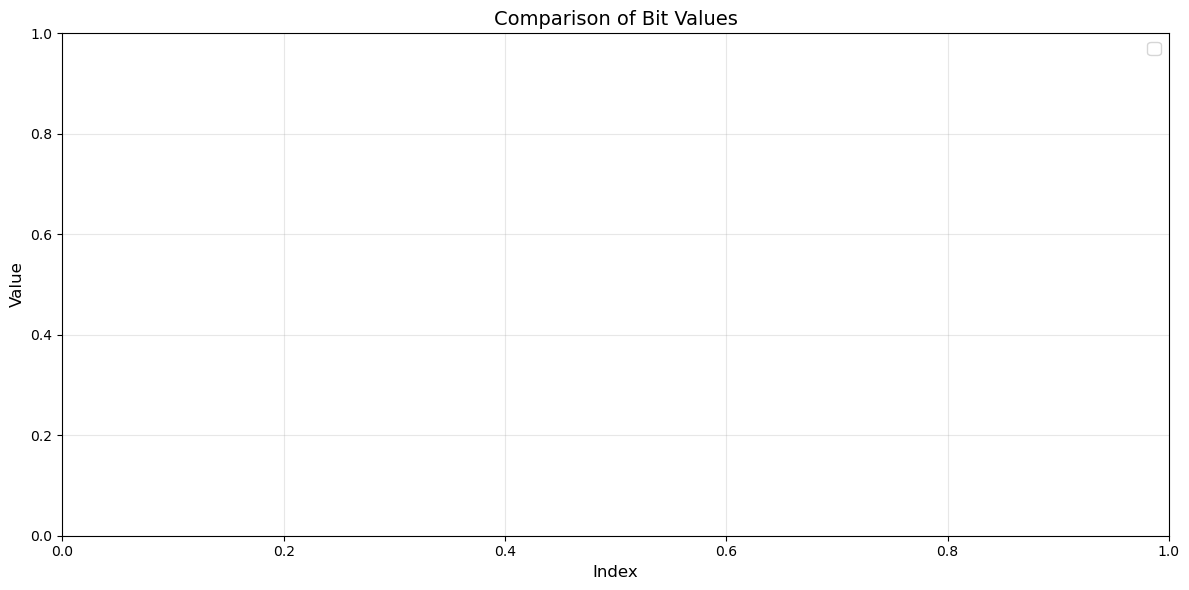

0


In [57]:
x = np.arange(0, 50)
# Create a figure and axis
plt.figure(figsize=(12, 6))
# Plot the absolute LLR values
#plt.plot(x, np.abs(llr1.numpy().flatten()[:100]), 'b-', label='abs(llr1)', linewidth=2)

# Plot the re-encoded bits (convert to numpy array if it's a tensor)
if isinstance(data_bits1, tf.Tensor):
     data_bits2 = data_bits1.numpy()

# # Plot the original encoded bits
if isinstance(dbar1, tf.Tensor):
    dbar2 = dbar1.numpy()

re_encoded_flat = data_bits1.flatten()[:50]
encoded_flat = dbar1.flatten()[:50]

# Find points where re_encoded_bits and encoded_bits differ
diff_indices = np.where(re_encoded_flat != encoded_flat)[0]

# Plot these points at a value of 100
if len(diff_indices) > 0:
    plt.scatter(diff_indices, np.ones_like(diff_indices) * 100, 
                color='purple', s=100, marker='x', label='Bit Differences')

# Plot the constant value of 10
#plt.axhline(y=10, color='k', linestyle='--', label='Threshold=10')

# Add labels and legend
plt.xlabel('Index', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Comparison of Bit Values', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()
print(len(diff_indices))


In [15]:
# Specifying certain parameters
# Number of pilots we transmit in a single retransmission
pilot_size = 50
# Number of packets that we predict channels for into the future incase of autoregressive or sequence modelling
packet_size = 50
# Order of the VAR we are using 
var_order = 25 
# Number of channel samples or total (pilot + packet) samples
N = 100000
# MSE threshold to decide when resampling is to be done
mse_threshold = 0.1
# SNR of the channel to determine the level of noise in the received signal
ebno_db = 10 
# Sampling frequency of the simulation
Fs = 100000 
# Number of initial pilots for VAR training
initial_pilots = 50

# Range of doppler frequencies to be explored in the plot - a total of 150 doppler frequencies
doppler_frequencies = np.linspace(0, 1700, 150)  
# Vectors to store the retransmission frequency and BER for plotting
retrans_frequencies = []
ber_values = []

# The simulation is performed 3 times to ensure averaging and smoothness of the curve
for Fd in doppler_frequencies:
    # Generate channels for current Doppler frequency
    generate_channels_for_doppler_frequencies(Fd, Fs, N)
    with open("channels.txt", "r") as f:
        channel_vals = [json.loads(line)[0] for line in f]
    channel_vals = np.array([complex(re, im) for re, im in channel_vals])
    
    retrans_frequency = 0
    ber = 0
    for i in range(3):
        # Call autoreg_simulate with all required parameters
        retrans_frequency1, ber1 = autoreg_simulate(
            Fd=Fd,
            Fs=Fs,
            channel_vals=channel_vals,
            mse_threshold=mse_threshold,
            N=N,
            ebno_db = ebno_db,
            packet_size=packet_size,
            pilot_size=pilot_size,
            var_order=var_order,
            initial_pilots=initial_pilots
        )
        retrans_frequency += retrans_frequency1
        ber += ber1 
    
    retrans_frequencies.append(retrans_frequency/3)
    ber_values.append(ber/3)

# Plot retransmission frequency vs normalized Doppler frequency
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(doppler_frequencies/Fs, retrans_frequencies, 'b-o', markersize=4)
plt.xlabel('Normalized Doppler Frequency (Fd/Fs)')
plt.ylabel('Retransmission Frequency')
plt.title('Retransmission Frequency vs Normalized Doppler')
plt.grid(True)

# Plot BER vs normalized Doppler frequency
plt.subplot(1, 2, 2)
plt.semilogy(doppler_frequencies/Fs, ber_values, 'r-o', markersize=4)
plt.xlabel('Normalized Doppler Frequency (Fd/Fs)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER vs Normalized Doppler')
plt.grid(True)

plt.tight_layout()
plt.show()

NameError: name 'autoreg_simulate' is not defined

# AR with LDPC algorithm

In [104]:
# # BATCH_SIZE = 1 # How many examples are processed by Sionna in parallel

# # bits = binary_source([BATCH_SIZE,1024]) # Blocklength
# # #print("Shape of bits: ", bits.shape)

# # x = mapper(bits)
# # #print("Shape of x: ", x.shape)

# # y = awgn_channel([x, no])
# # #print("Shape of y: ", y.shape)

# # llr = demapper([y, no])
# # #print("Shape of llr: ", llr.shape)


ldpc_encoder = sn.fec.ldpc.LDPC5GEncoder(k=packet_size, n=2*packet_size)
ldpc_decoder = sn.fec.ldpc.LDPC5GDecoder(encoder=ldpc_encoder, num_iter=50, hard_out=True, return_infobits=True)
data_bits = binary_source([1, 50]) 
encoded_bits = ldpc_encoder(data_bits)  # Tensor shape (1, 100)
x = mapper(encoded_bits)                  # Tensor shape (1, 100)
x = tf.squeeze(x).numpy() 
#print(x)


actual_channel = channel_vals[:len(x)]
y = transmit_data(x, actual_channel, ebno_db, coderate = 0.5)
y_eq = y / 1
y_eq_tensor = tf.convert_to_tensor(y_eq, dtype=tf.complex64)
y_eq_tensor = tf.reshape(y_eq_tensor, [1, -1])  # Add batch dimension

# print(y_eq_tensor)
# print(y)
# print(len(y_eq_tensor))


coderate = 0.5
signal_power = np.mean(np.abs(y)**2)
# Convert SNR from dB to linear scale and compute noise power.
# Manually computing the noise power based on signal power and SNR
no = tf.cast(signal_power / (10**(ebno_db / 10) * coderate), dtype=tf.float32)
llr = demapper([y_eq_tensor, no])
decoded_bits = ldpc_decoder(llr)

print(data_bits)
print(encoded_bits)
print(x)
print(decoded_bits)
print(y_eq_tensor.shape)
print(sn.utils.compute_ber(decoded_bits, data_bits))
# packet_size = 50
# ebno_db = 10
# coderate = 0.5
# ldpc_encoder = sn.fec.ldpc.LDPC5GEncoder(k=packet_size, n=2*packet_size)
# ldpc_decoder = sn.fec.ldpc.LDPC5GDecoder(encoder=ldpc_encoder, num_iter=50, hard_out=True, return_infobits=True) 
# bits = binary_source([1, 50])
# codewords = ldpc_encoder(bits)
# x = mapper(codewords)
# signal_power = np.mean(np.abs(x)**2)
# no = tf.cast(signal_power / (10**(ebno_db / 10) * coderate), dtype=tf.float32)
# y = awgn_channel([x, no])
# llr = demapper([y,no])
# bits_hat = ldpc_decoder(llr)

# print(bits[0][:5])
# print(codewords[0][:5])
# print(x[0][:5])
# print(llr[0][:5])
# print(bits_hat[0][:5])
# print(sn.utils.compute_ber(bits_hat, bits))



tf.Tensor(
[[1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1.
  0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1.
  0. 0.]], shape=(1, 50), dtype=float32)
tf.Tensor(
[[0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1.
  0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1.
  0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1.
  0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1.
  0. 1. 0. 1.]], shape=(1, 100), dtype=float32)
[ 1.+0.j  1.+0.j  1.+0.j -1.+0.j -1.+0.j -1.+0.j  1.+0.j  1.+0.j  1.+0.j
 -1.+0.j  1.+0.j -1.+0.j -1.+0.j -1.+0.j -1.+0.j -1.+0.j -1.+0.j  1.+0.j
 -1.+0.j -1.+0.j  1.+0.j  1.+0.j -1.+0.j -1.+0.j  1.+0.j -1.+0.j  1.+0.j
  1.+0.j  1.+0.j -1.+0.j  1.+0.j  1.+0.j -1.+0.j -1.+0.j  1.+0.j -1.+0.j
 -1.+0.j  1.+0.j -1.+0.j -1.+0.j  1.+0.j -1.+0.j -1.+0.j -1.+0.j -1.+0.j
  1.+0.j -1.+0.j -1.+0.j  1.+0.j  1.+0.j  1.+0.j  1.+0.j -1.+0.j  1.+0.j
  1.+0.

In [121]:
def autoreg_ldpc_simulate(Fd, Fs, channel_vals, mse_threshold, N, ebno_db, packet_size=50, pilot_size=50, var_order=25, initial_pilots=50):
    # Define code rate (rate 0.5 means k bits -> 2k bits)
    coderate = 0.5
    
    # Initialize Sionna components
    binary_source = sn.utils.BinarySource()
    constellation = sn.mapping.Constellation("pam", num_bits_per_symbol=1)
    mapper = sn.mapping.Mapper(constellation=constellation)
    demapper = sn.mapping.Demapper("app", constellation=constellation)
    
    # Initialize LDPC encoder and decoder with rate 0.5 (k bits -> 2k bits)
    # For 50 input bits, we'll get 100 coded bits
    ldpc_encoder = sn.fec.ldpc.LDPC5GEncoder(k=packet_size, n=2*packet_size)
    ldpc_decoder = sn.fec.ldpc.LDPC5GDecoder(encoder=ldpc_encoder, num_iter=50, hard_out=True, return_infobits=True)  

    # Maintain original control flow structure
    current_index = 0
    channel_estimates = []
    pilot_requests = []
    total_bits = 0
    wrong_bits = 0
    total_bits_ber = 0
    print_llr_count = 0
    pilot_bits = 0
    pilot_count = 0

    for _ in range(initial_pilots):
        pilot_bits = generate_random_bits(pilot_size)
        actual_channel = channel_vals[current_index:current_index + pilot_size]
        received_pilot = transmit_data(pilot_bits, actual_channel, ebno_db, coderate)
        hbar = estimate_channel(received_pilot, pilot_bits)
        channel_estimates.append(hbar)  
        current_index += pilot_size
        total_bits += pilot_size
        pilot_count += pilot_size


    while current_index < len(channel_vals) - (2*packet_size):  # Need space for encoded bits (2*packet_size)
        # VAR prediction (keep original numpy-based version)
        try:
            htilde = predict_channel_var(channel_history=channel_estimates,var_order=var_order)
        except ValueError:
            break

        data_bits = binary_source([1, packet_size])  # Tensor shape (1, 50)
        total_bits_ber += packet_size
        total_bits += packet_size
        encoded_bits = ldpc_encoder(data_bits)  # Tensor shape (1, 100)
        x = mapper(encoded_bits)                  # Tensor shape (1, 100)
        x = tf.squeeze(x).numpy()                 # Convert to numpy array (100,)

        actual_channel = channel_vals[current_index:current_index + len(x)]
        y = transmit_data(x, actual_channel, ebno_db, coderate = coderate)
        y_eq = y / htilde
        y_eq_tensor = tf.convert_to_tensor(y_eq, dtype=tf.complex64)
        y_eq_tensor = tf.reshape(y_eq_tensor, [1, -1])  # Add batch dimension
        current_index += len(x)

        signal_power = np.mean(np.abs(y)**2)
        htilde_mag_sq = tf.cast(tf.abs(htilde)**2, tf.float32)
        no = tf.cast(signal_power / (10**(ebno_db / 10) * coderate), dtype=tf.float32)
        no = no / htilde_mag_sq
        llr = demapper([y_eq_tensor, no])
        decoded_bits = ldpc_decoder(llr)  # Returns (1, 50) tensor with hard decisions (0/1)
        wrong_bits += (sn.utils.count_errors(decoded_bits, data_bits).numpy())
        
        # Step 3: Re-encode the decoded bits with LDPC
        re_encoded_bits = ldpc_encoder(decoded_bits)  # Tensor shape (1, 100)
        if print_llr_count == 0:
            llr1 = llr
            re_encoded_bits1 = re_encoded_bits
            encoded_bits1 = encoded_bits
        print_llr_count += 1
        re_encoded_symbols = mapper(re_encoded_bits)
        re_encoded_symbols = tf.squeeze(re_encoded_symbols).numpy()  # Convert to numpy array
        
        # Step 4: Get least squares estimate of channel with re-encoded bits
        hnought = estimate_channel(y, re_encoded_symbols)
        mse = np.abs(htilde - hnought)**2
        
        if mse > mse_threshold:
            pilot_bits = generate_random_bits(pilot_size)
            actual_channel = channel_vals[current_index:current_index + pilot_size]
            received_pilot = transmit_data(pilot_bits, actual_channel, ebno_db, coderate)
            hbar = estimate_channel(received_pilot, pilot_bits)
            channel_estimates.append(hbar)
            pilot_requests.append(current_index)
            current_index += pilot_size
            total_bits += pilot_size
            pilot_count += pilot_size

        else:
            # Use the re-estimated channel and proceed with the simulation.
            channel_estimates.append(hnought)

        if current_index >= N - (2*packet_size):
            break

    # Calculate the retransmission frequency (pilot-to-data ratio).
    retrans_frequency = np.float16(pilot_count/total_bits)
    
    # Calculate the bit error rate (BER).
    ber = np.float16(wrong_bits / total_bits_ber) if total_bits_ber > 0 else 0

    # Return the retransmission frequency and BER.
    return retrans_frequency, ber, llr1, re_encoded_bits1, encoded_bits1, total_bits_ber

In [26]:
Fs = 100000  # Sampling frequency
Fd = 100    # Doppler frequency
mse_threshold = 0.1  # Threshold for MSE
N = 100000   # Total samples
ebno_db = 10     # Signal-to-noise ratio in dB (interpreted as Eb/N0 for coded system)
packet_size = 50  # Bits per packet
pilot_size = 50  # Pilot bits
var_order = 25  # VAR model order
initial_pilots = 27  # Initial pilots

In [122]:
# Run simulation
retrans_frequency, ber, llr1, re_encoded_bits1, encoded_bits1, total_bits_ber = autoreg_ldpc_simulate(
    Fd=Fd, Fs=Fs, channel_vals=channel_vals, mse_threshold=mse_threshold,
    N=N, ebno_db = ebno_db, packet_size=packet_size, pilot_size=pilot_size,
    var_order=var_order, initial_pilots=initial_pilots
)

# Print results
print(f"Retransmission Frequency: {retrans_frequency}")
print(f"Bit Error Rate (BER): {ber}")
print(f"Data bits: {total_bits_ber}")

Retransmission Frequency: [ 1.69e-05  1.69e-05 -1.69e-05  1.69e-05  1.69e-05 -1.69e-05  1.69e-05
 -1.69e-05  1.69e-05  1.69e-05 -1.69e-05 -1.69e-05 -1.69e-05 -1.69e-05
 -1.69e-05 -1.69e-05 -1.69e-05 -1.69e-05 -1.69e-05 -1.69e-05 -1.69e-05
  1.69e-05  1.69e-05 -1.69e-05 -1.69e-05  1.69e-05 -1.69e-05  1.69e-05
  1.69e-05 -1.69e-05 -1.69e-05  1.69e-05  1.69e-05  1.69e-05  1.69e-05
 -1.69e-05  1.69e-05 -1.69e-05 -1.69e-05 -1.69e-05  1.69e-05 -1.69e-05
 -1.69e-05 -1.69e-05 -1.69e-05 -1.69e-05 -1.69e-05 -1.69e-05 -1.69e-05
 -1.69e-05]
Bit Error Rate (BER): 0.1256103515625
Data bits: 41000


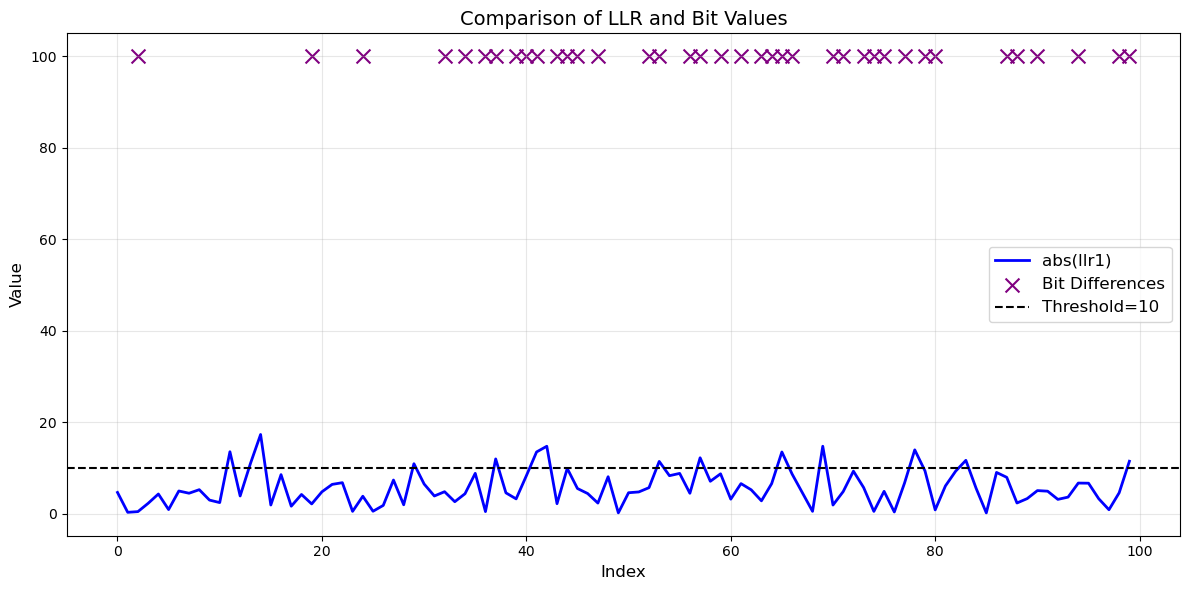

14


In [123]:
x = np.arange(0, 100)
# Create a figure and axis
plt.figure(figsize=(12, 6))
# Plot the absolute LLR values
plt.plot(x, np.abs(llr1.numpy().flatten()[:100]), 'b-', label='abs(llr1)', linewidth=2)

# Plot the re-encoded bits (convert to numpy array if it's a tensor)
if isinstance(re_encoded_bits1, tf.Tensor):
    re_encoded_bits1 = re_encoded_bits1.numpy()

# Plot the original encoded bits
if isinstance(encoded_bits1, tf.Tensor):
    encoded_bits1 = encoded_bits1.numpy()

re_encoded_flat = re_encoded_bits1.flatten()[:100]
encoded_flat = encoded_bits1.flatten()[:100]

# Find points where re_encoded_bits and encoded_bits differ
diff_indices = np.where(re_encoded_flat != encoded_flat)[0]

# Plot these points at a value of 100
if len(diff_indices) > 0:
    plt.scatter(diff_indices, np.ones_like(diff_indices) * 100, 
                color='purple', s=100, marker='x', label='Bit Differences')

# Plot the constant value of 10
plt.axhline(y=10, color='k', linestyle='--', label='Threshold=10')

# Add labels and legend
plt.xlabel('Index', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Comparison of LLR and Bit Values', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()
print(np.sum(diff_indices<50))


# LLR-based decision making

In [124]:
def autoreg_ldpc_simulate2(Fd, Fs, channel_vals, mse_threshold, N, ebno_db, packet_size=50, pilot_size=50, var_order=25, initial_pilots=50):
    # Define code rate (rate 0.5 means k bits -> 2k bits)
    coderate = 0.5
    
    # Initialize Sionna components
    binary_source = sn.utils.BinarySource()
    constellation = sn.mapping.Constellation("pam", num_bits_per_symbol=1)
    mapper = sn.mapping.Mapper(constellation=constellation)
    demapper = sn.mapping.Demapper("app", constellation=constellation)
    
    # Initialize LDPC encoder and decoder with rate 0.5 (k bits -> 2k bits)
    # For 50 input bits, we'll get 100 coded bits
    ldpc_encoder = sn.fec.ldpc.LDPC5GEncoder(k=packet_size, n=2*packet_size)
    ldpc_decoder = sn.fec.ldpc.LDPC5GDecoder(encoder=ldpc_encoder, num_iter=50, hard_out=True, return_infobits=True)  

    # Maintain original control flow structure
    current_index = 0
    channel_estimates = []
    pilot_requests = []
    total_bits = 0
    wrong_bits = 0
    total_bits_ber = 0
    print_llr_count = 0
    pilot_bits = 0
    pilot_count = 0
    LLR_threshold = 5
    LLR_fraction = 0.1


    for _ in range(initial_pilots):
        pilot_bits = generate_random_bits(pilot_size)
        actual_channel = channel_vals[current_index:current_index + pilot_size]
        received_pilot = transmit_data(pilot_bits, actual_channel, ebno_db, coderate)
        hbar = estimate_channel(received_pilot, pilot_bits)
        channel_estimates.append(hbar)  
        current_index += pilot_size
        total_bits += pilot_size
        pilot_count += pilot_size


    while current_index < len(channel_vals) - (2*packet_size):  # Need space for encoded bits (2*packet_size)
        # VAR prediction (keep original numpy-based version)
        try:
            htilde = predict_channel_var(channel_history=channel_estimates,var_order=var_order)
        except ValueError:
            break

        data_bits = binary_source([1, packet_size])  # Tensor shape (1, 50)
        total_bits_ber += packet_size
        total_bits += packet_size
        encoded_bits = ldpc_encoder(data_bits)  # Tensor shape (1, 100)
        x = mapper(encoded_bits)                  # Tensor shape (1, 100)
        x = tf.squeeze(x).numpy()                 # Convert to numpy array (100,)

        actual_channel = channel_vals[current_index:current_index + len(x)]
        y = transmit_data(x, actual_channel, ebno_db, coderate = coderate)
        y_eq = y / htilde
        y_eq_tensor = tf.convert_to_tensor(y_eq, dtype=tf.complex64)
        y_eq_tensor = tf.reshape(y_eq_tensor, [1, -1])  # Add batch dimension
        current_index += len(x)

        signal_power = np.mean(np.abs(y)**2)
        htilde_mag_sq = tf.cast(tf.abs(htilde)**2, tf.float32)
        no = tf.cast(signal_power / (10**(ebno_db / 10) * coderate), dtype=tf.float32)
        no = no / htilde_mag_sq
        llr = demapper([y_eq_tensor, no])
        decoded_bits = ldpc_decoder(llr)  # Returns (1, 50) tensor with hard decisions (0/1)
        wrong_bits += (sn.utils.count_errors(decoded_bits, data_bits).numpy())
        
        # Step 3: Re-encode the decoded bits with LDPC
        re_encoded_bits = ldpc_encoder(decoded_bits)  # Tensor shape (1, 100)
        if print_llr_count == 0:
            llr1 = llr
            re_encoded_bits1 = re_encoded_bits
            encoded_bits1 = encoded_bits
        print_llr_count += 1
        re_encoded_symbols = mapper(re_encoded_bits)
        re_encoded_symbols = tf.squeeze(re_encoded_symbols).numpy()  # Convert to numpy array
         
        # Step 4: Get least squares estimate of channel with re-encoded bits
        hnought = estimate_channel(y, re_encoded_symbols)

        # Determine if the number of values that go below LLR_threshold in a specific iteration exceeds a certain fraction of the total coded size 
        llr_abs = np.abs(llr.numpy().flatten())
        unreliable_llr_count = np.sum(llr_abs < LLR_threshold)
        total_llr_bits = len(llr_abs)
        
        if unreliable_llr_count > LLR_fraction * total_llr_bits:
            pilot_bits = generate_random_bits(pilot_size)
            actual_channel = channel_vals[current_index:current_index + pilot_size]
            received_pilot = transmit_data(pilot_bits, actual_channel, ebno_db, coderate)
            hbar = estimate_channel(received_pilot, pilot_bits)
            channel_estimates.append(hbar)  
            current_index += pilot_size
            total_bits += pilot_size
            pilot_count += pilot_size
        else:
            # Use the re-estimated channel and proceed with the simulation.
            channel_estimates.append(hnought)
            
        if current_index >= N - (2*packet_size):
            break

    # Calculate the retransmission frequency (pilot-to-data ratio).
    retrans_frequency = np.float16(pilot_count/total_bits)
    
    # Calculate the bit error rate (BER).
    ber = np.float16(wrong_bits / total_bits_ber) if total_bits_ber > 0 else 0

    # Return the retransmission frequency and BER.
    return retrans_frequency, ber, llr1, re_encoded_bits1, encoded_bits1, total_bits_ber

In [142]:
# # Set parameters
# Fs = 100000  # Sampling frequency
# Fd = 1000    # Doppler frequency
# mse_threshold = 0.1  # Threshold for MSE
# N = 100000   # Total samples
# ebno_db = 10     # Signal-to-noise ratio in dB (interpreted as Eb/N0 for coded system)
# packet_size = 30  # Bits per packet
# pilot_size = 20  # Pilot bits
# var_order = 20  # VAR model order
# initial_pilots = 22  # Initial pilots

# # Generate and load channels
# generate_channels_for_doppler_frequencies(Fd, Fs, N)
# with open("channels.txt", "r") as f:
#     channel_vals = [json.loads(line)[0] for line in f]
# channel_vals = np.array([complex(re, im) for re, im in channel_vals])

In [125]:
# Run simulation
retrans_frequency, ber, llr1, re_encoded_bits1, encoded_bits1, total_bits_ber = autoreg_ldpc_simulate2(
    Fd=Fd, Fs=Fs, channel_vals=channel_vals, mse_threshold=mse_threshold,
    N=N, ebno_db = ebno_db, packet_size=packet_size, pilot_size=pilot_size,
    var_order=var_order, initial_pilots=initial_pilots
)

# Print results
print(f"Retransmission Frequency: {retrans_frequency}")
print(f"Bit Error Rate (BER): {ber}")
print(f"Data bits: {total_bits_ber}")

Retransmission Frequency: 0.247314453125
Bit Error Rate (BER): 0.044097900390625
Data bits: 42900


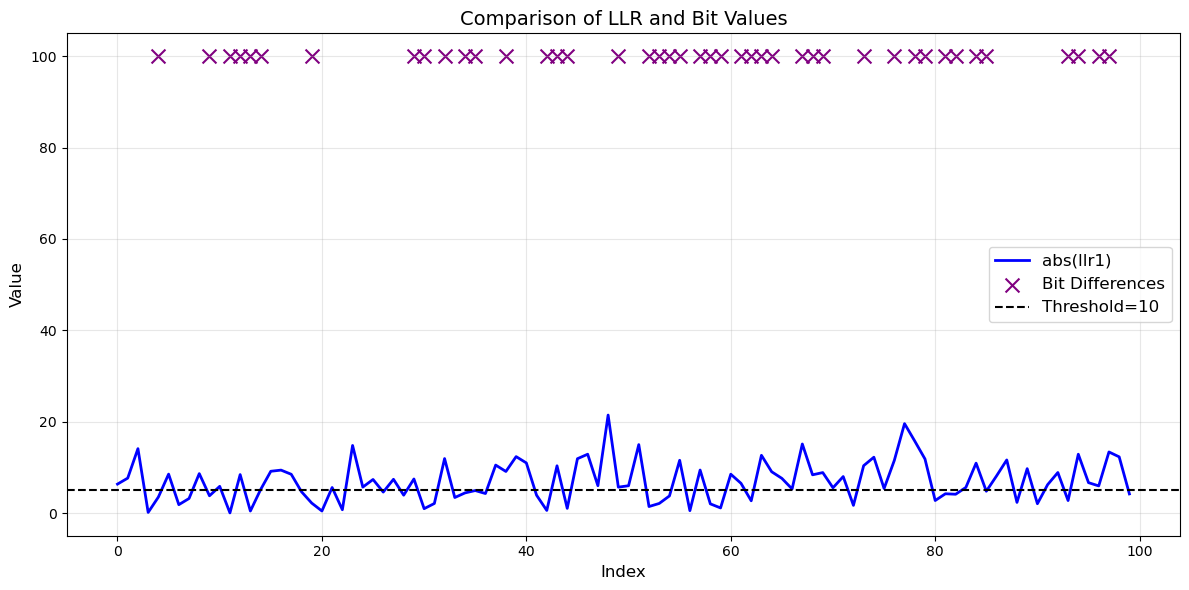

17


In [128]:
x = np.arange(0, 100)
# Create a figure and axis
plt.figure(figsize=(12, 6))
# Plot the absolute LLR values
plt.plot(x, np.abs(llr1.numpy().flatten()[:100]), 'b-', label='abs(llr1)', linewidth=2)

# Plot the re-encoded bits (convert to numpy array if it's a tensor)
if isinstance(re_encoded_bits1, tf.Tensor):
    re_encoded_bits1 = re_encoded_bits1.numpy()

# Plot the original encoded bits
if isinstance(encoded_bits1, tf.Tensor):
    encoded_bits1 = encoded_bits1.numpy()

re_encoded_flat = re_encoded_bits1.flatten()[:100]
encoded_flat = encoded_bits1.flatten()[:100]

# Find points where re_encoded_bits and encoded_bits differ
diff_indices = np.where(re_encoded_flat != encoded_flat)[0]

# Plot these points at a value of 100
if len(diff_indices) > 0:
    plt.scatter(diff_indices, np.ones_like(diff_indices) * 100, 
                color='purple', s=100, marker='x', label='Bit Differences')

# Plot the constant value of 10
plt.axhline(y=5, color='k', linestyle='--', label='Threshold=10')

# Add labels and legend
plt.xlabel('Index', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Comparison of LLR and Bit Values', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()
print(np.sum(diff_indices<50))


In [ ]:
# Specifying certain parameters
# Number of pilots we transmit in a single retransmission
pilot_size = 50
# Number of packets that we predict channels for into the future incase of autoregressive or sequence modelling
packet_size = 50
# Order of the VAR we are using 
var_order = 25 
# Number of channel samples or total (pilot + packet) samples
N = 100000
# MSE threshold to decide when resampling is to be done
mse_threshold = 0.1
# SNR of the channel to determine the level of noise in the received signal
ebno_db = 10 
# Sampling frequency of the simulation
Fs = 100000 
# Number of initial pilots for VAR training
initial_pilots = 27

# Range of doppler frequencies to be explored in the plot - a total of 150 doppler frequencies
doppler_frequencies = np.linspace(0, 1700, 300)  
# Vectors to store the retransmission frequency and BER for plotting
retrans_frequencies = []
ber_values = []

# The simulation is performed 3 times to ensure averaging and smoothness of the curve
for Fd in doppler_frequencies:
    # Generate channels for current Doppler frequency
    generate_channels_for_doppler_frequencies(Fd, Fs, N)
    with open("channels.txt", "r") as f:
        channel_vals = [json.loads(line)[0] for line in f]
    channel_vals = np.array([complex(re, im) for re, im in channel_vals])
    
    retrans_frequency = 0
    ber = 0
    for i in range(3):
        # Call autoreg_simulate with all required parameters
        retrans_frequency1, ber1 = autoreg_ldpc_simulate(
            Fd=Fd,
            Fs=Fs,
            channel_vals=channel_vals,
            mse_threshold=mse_threshold,
            N=N,
            ebno_db = ebno_db,
            packet_size=packet_size,
            pilot_size=pilot_size,
            var_order=var_order,
            initial_pilots=initial_pilots
        )
        retrans_frequency += retrans_frequency1
        ber += ber1 
    
    retrans_frequencies.append(retrans_frequency/3)
    ber_values.append(ber/3)

# Plot retransmission frequency vs normalized Doppler frequency
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(doppler_frequencies/Fs, retrans_frequencies, 'b-o', markersize=4)
plt.xlabel('Normalized Doppler Frequency (Fd/Fs)')
plt.ylabel('Retransmission Frequency')
plt.title('Retransmission Frequency vs Normalized Doppler - LDPC')
plt.grid(True)

# Plot BER vs normalized Doppler frequency
plt.subplot(1, 2, 2)
plt.semilogy(doppler_frequencies/Fs, ber_values, 'r-o', markersize=4)
plt.xlabel('Normalized Doppler Frequency (Fd/Fs)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('BER vs Normalized Doppler - LDPC')
plt.grid(True)

plt.tight_layout()
plt.show()

# LLR-based decision making with CRC(Cyclic Redundancy Checks)

Some changes made:
1. Increased LDPC iteration count to improve correlation between bit errors and LLR values
2. Reduced Doppler and tweaked some parameters - Fs, Fd to try to improve BER performance
3. CRC is used after LDPC encoding, and then upon reception, check if the CRC bits are right. If they are right, go ahead with LLR computation. If not, then use LLR based decision making
4. Bits - CRC - LDPC Encode - Receive - LDPC Decode - CRC check - If true, check LLRs by using extended LDPC vector, if False, request pilot retransmission. 
5. For numerical stability, the decoder applies LLR clipping of +/- 20 to the input LLRs - LDPC Decoding. 

In [140]:
def autoreg_ldpc_simulate3(Fd, Fs, channel_vals, mse_threshold, N, ebno_db, packet_size=50, pilot_size=50, var_order=25, initial_pilots=50):
    # Define code rate (rate 0.5 means k bits -> 2k bits)
    coderate = 0.5
    
    # Initialize Sionna components
    binary_source = sn.utils.BinarySource()
    constellation = sn.mapping.Constellation("pam", num_bits_per_symbol=1)
    mapper = sn.mapping.Mapper(constellation=constellation)
    demapper = sn.mapping.Demapper("app", constellation=constellation)

    CRCencoder = sn.fec.crc.CRCEncoder(crc_degree="CRC16") # the crc_degree denotes the number of added parity bits and is taken from the 3GPP 5G NR standard.
    CRCdecoder = sn.fec.crc.CRCDecoder(crc_encoder=CRCencoder) # the decoder must be associated to a specific encoder
    crc_deg = 16
    
    # Initialize LDPC encoder and decoder with rate 0.5 (k bits -> 2k bits)
    # For 50 input bits, we'll get 100 coded bits
    ldpc_encoder_crc = sn.fec.ldpc.LDPC5GEncoder(k=packet_size + crc_deg, n=2*(packet_size + crc_deg))
    ldpc_decoder_crc = sn.fec.ldpc.LDPC5GDecoder(encoder=ldpc_encoder_crc, num_iter=50, hard_out=True, return_infobits=True) 
    ldpc_encoder = sn.fec.ldpc.LDPC5GEncoder(k=packet_size, n=2*(packet_size))
    ldpc_decoder = sn.fec.ldpc.LDPC5GDecoder(encoder=ldpc_encoder, num_iter=50, hard_out=True, return_infobits=True)   

    # Maintain original control flow structure
    current_index = 0
    channel_estimates = []
    pilot_requests = []
    total_bits = 0
    wrong_bits = 0
    total_bits_ber = 0
    print_llr_count = 0
    pilot_bits = 0
    pilot_count = 0
    LLR_threshold = 5
    LLR_fraction = 0.1

    for _ in range(initial_pilots):
        pilot_bits = generate_random_bits(pilot_size)
        actual_channel = channel_vals[current_index:current_index + pilot_size]
        received_pilot = transmit_data(pilot_bits, actual_channel, ebno_db, coderate)
        hbar = estimate_channel(received_pilot, pilot_bits)
        channel_estimates.append(hbar)  
        current_index += pilot_size
        total_bits += pilot_size
        pilot_count += pilot_size

    while current_index < len(channel_vals) - (2*packet_size) - (2*crc_deg):  # Need space for encoded bits (2*packet_size)
        # VAR prediction (keep original numpy-based version)
        try:
            htilde = predict_channel_var(channel_history=channel_estimates,var_order=var_order)
        except ValueError:
            break

        data_bits = binary_source([1, packet_size])  # Tensor shape (1, 50)
        data_bits_crc = CRCencoder(data_bits)
        total_bits_ber += packet_size
        total_bits += packet_size
        encoded_bits = ldpc_encoder_crc(data_bits_crc)  # Tensor shape (1, 100)
        x = mapper(encoded_bits)                  # Tensor shape (1, 100)
        x = tf.squeeze(x).numpy()                 # Convert to numpy array (100,)

        actual_channel = channel_vals[current_index:current_index + len(x)]
        y = transmit_data(x, actual_channel, ebno_db, coderate = coderate)
        y_eq = y / htilde
        y_eq_tensor = tf.convert_to_tensor(y_eq, dtype=tf.complex64)
        y_eq_tensor = tf.reshape(y_eq_tensor, [1, -1])  # Add batch dimension
        current_index += len(x)

        signal_power = np.mean(np.abs(y)**2)
        htilde_mag_sq = tf.cast(tf.abs(htilde)**2, tf.float32)
        no = tf.cast(signal_power / (10**(ebno_db / 10) * coderate), dtype=tf.float32)
        no = no / htilde_mag_sq
        llr = demapper([y_eq_tensor, no])
        decoded_bits = ldpc_decoder_crc(llr)  # Returns (1, 50) tensor with hard decisions (0/1)

        data_bits_decoded, crc_check = CRCdecoder(decoded_bits)

        if not crc_check:
            pilot_bits = generate_random_bits(pilot_size)
            actual_channel = channel_vals[current_index:current_index + pilot_size]
            received_pilot = transmit_data(pilot_bits, actual_channel, ebno_db, coderate)
            hbar = estimate_channel(received_pilot, pilot_bits)
            channel_estimates.append(hbar)  
            current_index += pilot_size
            total_bits += pilot_size
            pilot_count += pilot_size
            continue

        wrong_bits += (sn.utils.count_errors(data_bits_decoded, data_bits).numpy())
        # Step 3: Re-encode the decoded bits with LDPC
        re_encoded_bits = ldpc_encoder_crc(decoded_bits)  # Tensor shape (1, 100)
        if print_llr_count == 0:
            llr1 = llr
            re_encoded_bits1 = re_encoded_bits
            encoded_bits1 = encoded_bits
        print_llr_count += 1
        re_encoded_symbols = mapper(re_encoded_bits)
        re_encoded_symbols = tf.squeeze(re_encoded_symbols).numpy()  # Convert to numpy array
        
        hnought = estimate_channel(y, re_encoded_symbols)
        # Determine if the number of values that go below LLR_threshold in a specific iteration exceeds a certain fraction of the total coded size 
        llr_abs = np.abs(llr.numpy().flatten())
        unreliable_llr_count = np.sum(llr_abs < LLR_threshold)
        total_llr_bits = len(llr_abs)
        
        if unreliable_llr_count > LLR_fraction * total_llr_bits:
            pilot_bits = generate_random_bits(pilot_size)
            actual_channel = channel_vals[current_index:current_index + pilot_size]
            received_pilot = transmit_data(pilot_bits, actual_channel, ebno_db, coderate)
            hbar = estimate_channel(received_pilot, pilot_bits)
            channel_estimates.append(hbar)  
            current_index += pilot_size
            total_bits += pilot_size
            pilot_count += pilot_size
        else:
            # Use the re-estimated channel and proceed with the simulation.
            channel_estimates.append(hnought)
            
        if current_index >= N - (2*packet_size):
            break

    # Calculate the retransmission frequency (pilot-to-data ratio).
    retrans_frequency = np.float16(pilot_count/total_bits)
    
    # Calculate the bit error rate (BER).
    ber = np.float16(wrong_bits / total_bits_ber) if total_bits_ber > 0 else 0

    # Return the retransmission frequency and BER.
    return retrans_frequency, ber, llr1, re_encoded_bits1, encoded_bits1, total_bits_ber


In [138]:
# # Set parameters
# Fs = 100000  # Sampling frequency
# Fd = 1000    # Doppler frequency
# mse_threshold = 0.1  # Threshold for MSE
# N = 100000   # Total samples
# ebno_db = 10     # Signal-to-noise ratio in dB (interpreted as Eb/N0 for coded system)
# packet_size = 30  # Bits per packet
# pilot_size = 20  # Pilot bits
# var_order = 20  # VAR model order
# initial_pilots = 22  # Initial pilots

# # Generate and load channels
# generate_channels_for_doppler_frequencies(Fd, Fs, N)
# with open("channels.txt", "r") as f:
#     channel_vals = [json.loads(line)[0] for line in f]
# channel_vals = np.array([complex(re, im) for re, im in channel_vals])

In [141]:
# Run simulation
retrans_frequency, ber, llr1, re_encoded_bits1, encoded_bits1, total_bits_ber = autoreg_ldpc_simulate3(
    Fd=Fd, Fs=Fs, channel_vals=channel_vals, mse_threshold=mse_threshold,
    N=N, ebno_db = ebno_db, packet_size=packet_size, pilot_size=pilot_size,
    var_order=var_order, initial_pilots=initial_pilots
)

# Print results
print(f"Retransmission Frequency: {retrans_frequency}")
print(f"Bit Error Rate (BER): {ber}")
print(f"Data bits: {total_bits_ber}")

Retransmission Frequency: 0.318115234375
Bit Error Rate (BER): 0.0
Data bits: 32150


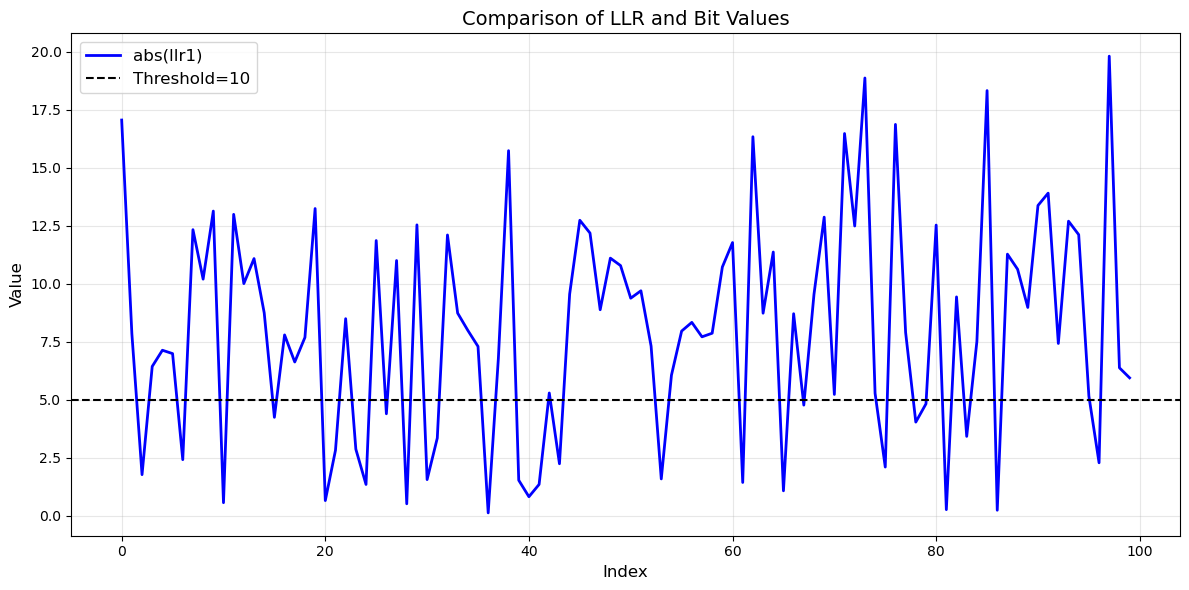

0


In [142]:
x = np.arange(0, 100)
# Create a figure and axis
plt.figure(figsize=(12, 6))
# Plot the absolute LLR values
plt.plot(x, np.abs(llr1.numpy().flatten()[:100]), 'b-', label='abs(llr1)', linewidth=2)

# Plot the re-encoded bits (convert to numpy array if it's a tensor)
if isinstance(re_encoded_bits1, tf.Tensor):
    re_encoded_bits1 = re_encoded_bits1.numpy()

# Plot the original encoded bits
if isinstance(encoded_bits1, tf.Tensor):
    encoded_bits1 = encoded_bits1.numpy()

re_encoded_flat = re_encoded_bits1.flatten()[:100]
encoded_flat = encoded_bits1.flatten()[:100]

# Find points where re_encoded_bits and encoded_bits differ
diff_indices = np.where(re_encoded_flat != encoded_flat)[0]

# Plot these points at a value of 100
if len(diff_indices) > 0:
    plt.scatter(diff_indices, np.ones_like(diff_indices) * 100, 
                color='purple', s=100, marker='x', label='Bit Differences')

# Plot the constant value of 10
plt.axhline(y=5, color='k', linestyle='--', label='Threshold=10')

# Add labels and legend
plt.xlabel('Index', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Comparison of LLR and Bit Values', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()
print(np.sum(diff_indices<50))
